# Graph Colouring

### Importing Libraries

In [1]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
from braket.devices import LocalSimulator
import numpy as np
import math

The graph colouring problem that we are considering requires the condition that no two adjacent nodes of the matrix (horizontally and vertically adjacent) can have the same colour (denoted by 0 and 1, representing two colours). Hence, we need to modify our Oracle to consider these constraints. We can consider the below example - <br>
If the matrix with its indices are as follows <br>
|0,1|<br>
|2,3|<br>
then the following list of pairs of indices cannot be coloured the same. <br>
[[0,1], [0,2], [1,3], [2,3]] <br>
Hence, the program can either colour it as <br>
|0,1| <br>
|1,0|<br>
OR <br>
|1,0| <br>
|0,1| <br>

<h3>Defining the Problem Conditions

In [2]:
problem_conditions = [[0,1], [0,2], [1,3], [2,3]]

### Defining Device and Results Folder

In [3]:
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
# device = AwsDevice('arn:aws:braket:::device/quantum-simulator/amazon/sv1')
device = LocalSimulator()
s3_folder = (f"amazon-braket-1c440ad1b4a7","Simulator")


### Implementing the Oracle Part

In [4]:
oracle_1 = Circuit()

for i in range(len(problem_conditions)):
    oracle_1.cnot(problem_conditions[i][0], 4+i)
    oracle_1.cnot(problem_conditions[i][1], 4+i)

oracle_1.ccnot(4,5,8)
oracle_1.ccnot(6,8,9)
oracle_1.ccnot(7,9,10)

oracle_1.cnot(10,11)


oracle_1.ccnot(7,9,10)
oracle_1.ccnot(6,8,9)
oracle_1.ccnot(4,5,8)


oracle=oracle_1
print(oracle)

T   : |0| 1 | 2 |  3  | 4 |5|6|7|8|9|
                                     
q0  : -C---C-------------------------
       |   |                         
q1  : -|-C-|---C---------------------
       | | |   |                     
q2  : -|-|-|-C-|---C-----------------
       | | | | |   |                 
q3  : -|-|-|-|-|-C-|---C-------------
       | | | | | | |   |             
q4  : -X-X-|-|-|-|-|-C-|-----------C-
           | | | | | | |           | 
q5  : -----X-X-|-|-|-C-|-----------C-
               | | | | |           | 
q6  : ---------X-X-|-|-|-C-------C-|-
                   | | | |       | | 
q7  : -------------X-|-X-|-C---C-|-|-
                     |   | |   | | | 
q8  : ---------------X---C-|---|-C-X-
                         | |   | |   
q9  : -------------------X-C---C-X---
                           |   |     
q10 : ---------------------X-C-X-----
                             |       
q11 : -----------------------X-------

T   : |0| 1 | 2 |  3  | 4 |5|6|7|8|9|


In [5]:
oracle_2 = Circuit()

for i in range(len(problem_conditions)):
    oracle_2.cnot(problem_conditions[i][0], 4+i)
    oracle_2.cnot(problem_conditions[i][1], 4+i)


oracle=oracle.add(oracle_2)
print(oracle)

T   : |0| 1 | 2 |  3  | 4 |5|6|7|8|9|10|11 |12 |13 |14|
                                                       
q0  : -C---C-------------------------C----C------------
       |   |                         |    |            
q1  : -|-C-|---C---------------------|--C-|---C--------
       | | |   |                     |  | |   |        
q2  : -|-|-|-C-|---C-----------------|--|-|-C-|---C----
       | | | | |   |                 |  | | | |   |    
q3  : -|-|-|-|-|-C-|---C-------------|--|-|-|-|-C-|-C--
       | | | | | | |   |             |  | | | | | | |  
q4  : -X-X-|-|-|-|-|-C-|-----------C-X--X-|-|-|-|-|-|--
           | | | | | | |           |      | | | | | |  
q5  : -----X-X-|-|-|-C-|-----------C------X-X-|-|-|-|--
               | | | | |           |          | | | |  
q6  : ---------X-X-|-|-|-C-------C-|----------X-X-|-|--
                   | | | |       | |              | |  
q7  : -------------X-|-X-|-C---C-|-|--------------X-X--
                     |   | |   | | |            

In [6]:
temp=[]
for i in range(16):
    
    temp.append([])
    for j in range(16):
        if(i==j):
            if(i==15):
                temp[i].append(-1.0)
            else:
                temp[i].append(1.0)
        else:
            temp[i].append(0.0)

custom_gate = np.array(temp)

amplify = Circuit()

amplify.h([0,1,2,3])
amplify.x([0,1,2,3]).unitary(matrix=custom_gate, targets=[0,1,2,3]).x([0,1,2,3])
amplify.h([0,1,2,3])

print(amplify)

T  : |0|1|2|3|4|
                
q0 : -H-X-U-X-H-
          |     
q1 : -H-X-U-X-H-
          |     
q2 : -H-X-U-X-H-
          |     
q3 : -H-X-U-X-H-

T  : |0|1|2|3|4|


In [7]:
# Sudoku Solver

sudoku = Circuit()
sudoku.x([11]).h([0,1,2,3,11])
for i in range(2):
    sudoku.add(oracle)
    sudoku.add(amplify)
print(sudoku)



T   : |0|1| 2 | 3 |  4  | 5 |6|7|8|9|10|11|12 |13 |14 |15|16|17|18|19|20|21|22 |23 | 24  |25 |26|27|28|29|30|31|32 |33 |34 |35|36|37|38|39|40|
                                                                                                                                              
q0  : -H-C---C--------------------------C----C-H---X------------U--X--H--C----C------------------------------C----C-H---X------------U--X--H--
         |   |                          |    |                  |        |    |                              |    |                  |        
q1  : -H-|-C-|---C----------------------|--C-|---C-H---X--------U--X--H--|--C-|---C--------------------------|--C-|---C-H---X--------U--X--H--
         | | |   |                      |  | |   |              |        |  | |   |                          |  | |   |              |        
q2  : -H-|-|-|-C-|---C------------------|--|-|-C-|---C-H--X-----U--X--H--|--|-|-C-|---C----------------------|--|-|-C-|---C-H--X-----U--X--H--

In [8]:
counts = device.run(sudoku, shots = 1000).result().measurement_counts



In [9]:
solutions=[]
total_times=[]

for key, value in counts.items():
    if(key[:4] not in solutions):
        solutions.append(key[:4])
        total_times.append(0)
    total_times[solutions.index(key[:4])] += value

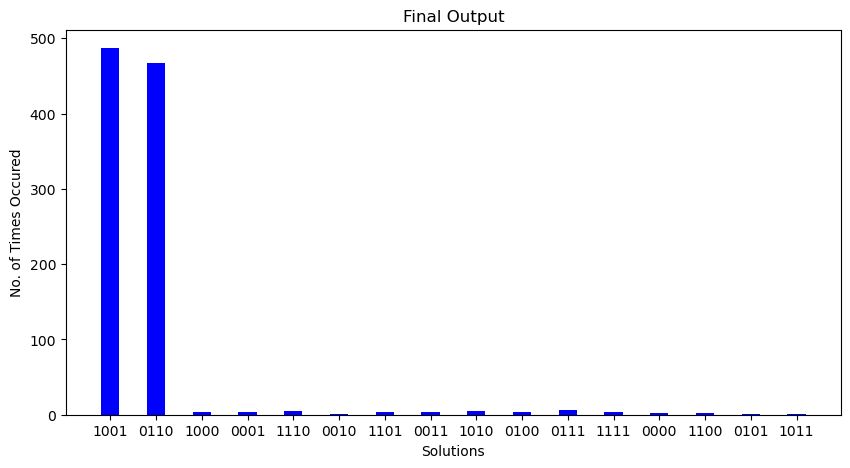

In [10]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(solutions, total_times, color ='blue',
        width = 0.4)
 
plt.xlabel("Solutions")
plt.ylabel("No. of Times Occured")
plt.title("Final Output")
plt.show()

As we see in the graph above, the solutions 0110 and 1001 have overwhelmingly occured the most number of times, consistent with our required solution set. The rest of the solutions are just noise that has been generated during computation.<br><br>
Consider the below colouring pattern where Red is denoted by 0 and Yellow is denoted by 1.

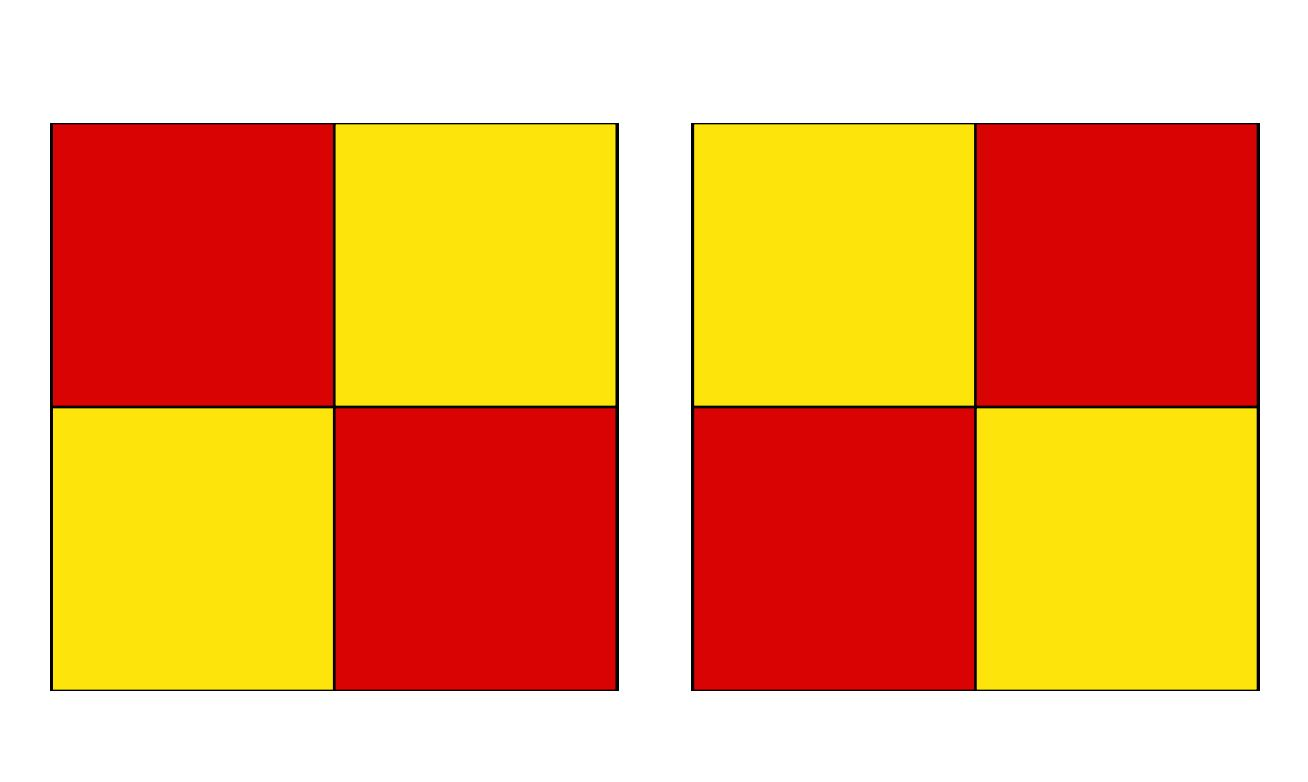